In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
# Enhanced data loading and preprocessing
def load_and_preprocess(filepath):
    df = pq.read_table('/content/drive/MyDrive/True baecon Assignmet/data.parquet').to_pandas()
    df.index = pd.to_datetime(df.index)
    df = df.between_time('09:15', '15:30')
    df['date'] = df.index.date

    # Remove holidays
    holiday_dates = []
    for date in df['date'].unique():
        df_date = df[df['date'] == date]
        if len(df_date['nifty'].unique()) == 1 or len(df_date['banknifty'].unique()) == 1:
            holiday_dates.append(date)
    df = df[~df['date'].isin(holiday_dates)]

    # Forward fill missing values
    df[['nifty', 'banknifty', 'tte']] = df[['nifty', 'banknifty', 'tte']].ffill().bfill()

    return df
df = load_and_preprocess('data.parquet')

In [30]:
df

,banknifty,nifty,tte,date
time,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,2021-01-01
2021-01-01 09:16:00,0.285381,0.200433,27,2021-01-01
2021-01-01 09:17:00,0.284233,0.200004,27,2021-01-01
2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01
2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01
...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30
2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30
2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


{datetime.date(2021, 1, 1): np.float64(0.9486302577523773), datetime.date(2021, 1, 4): np.float64(0.6639540338162357), datetime.date(2021, 1, 5): np.float64(0.6514118186798666), datetime.date(2021, 1, 6): np.float64(0.5648437175206688), datetime.date(2021, 1, 7): np.float64(0.05306696834400327), datetime.date(2021, 1, 8): np.float64(0.31238464980529546), datetime.date(2021, 1, 11): np.float64(0.81952376060208), datetime.date(2021, 1, 12): np.float64(0.05899226764538753), datetime.date(2021, 1, 13): np.float64(0.7782890604687721), datetime.date(2021, 1, 14): np.float64(0.8728054720815691), datetime.date(2021, 1, 15): np.float64(0.48997838211454714), datetime.date(2021, 1, 17): np.float64(1.0), datetime.date(2021, 1, 18): np.float64(0.8122334883293328), datetime.date(2021, 1, 19): np.float64(0.9464448940270148), datetime.date(2021, 1, 20): np.float64(0.9027525882199384), datetime.date(2021, 1, 21): np.float64(0.8465352800446755), datetime.date(2021, 1, 22): np.float64(0.9033496752684319)

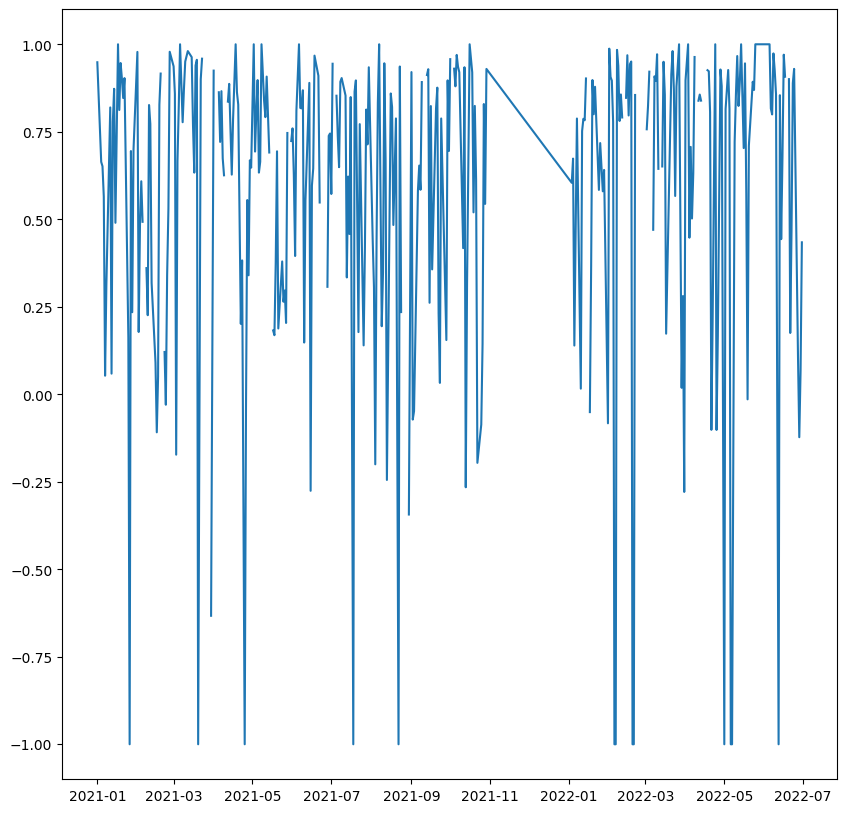

In [31]:
corr ={}
day_diffn=[]
day_diffb=[]
plt.figure(figsize=(10,10))
closeb,closen=-2,-2
for dates in df['date'].unique():
    df_=df[df['date']==dates]
    if(closen !=-2):
        day_diffn.append(abs(closen-df_.iloc[0]['nifty']))
    if(closeb !=-2):
        day_diffb.append(abs(closeb-df_.iloc[0]['banknifty']))
    closen=df_.iloc[-1]['nifty']
    closeb=df_.iloc[-1]['banknifty']
    corr[dates]=df_['nifty'].corr(df_['banknifty'])
print(corr)
plt.plot(corr.keys(),corr.values())
plt.show()


# Statistical test to :
# 1. Identify meaning reverting condition
# 2. Test whether time series is stationanry or not

In [34]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

# Enhanced Stationarity Check
def check_stationarity(series, name="Series"):
    result = adfuller(series.dropna())
    print(f"\n{name} Stationarity Analysis")
    print("="*50)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")

    if result[1] < 0.05:
        print("Conclusion: Reject null hypothesis - series is stationary")
    else:
        print("Conclusion: Cannot reject null hypothesis - series is non-stationary")

# Hurst Exponent Calculation
def hurst_exponent(ts):
    """Returns the Hurst Exponent of the time series"""
    ts = ts[~np.isnan(ts)]
    if len(ts) < 100:
        print("Warning: Time series too short for reliable Hurst calculation")

    lags = range(10, min(len(ts)//2, 100))
    tau = [sqrt(np.std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

def interpret_hurst(h):
    print(f"\nHurst Exponent: {h:.4f}")
    if h > 0.55:
        print("Interpretation: Trending series (persistent)")
    elif h < 0.45:
        print("Interpretation: Mean-reverting series")
    else:
        print("Interpretation: Random walk")

# Apply to your data
iv_spread = df['banknifty'] - df['nifty']

# 1. Stationarity Test
check_stationarity(iv_spread, "IV Spread")

# 2. Hurst Exponent Analysis
h = hurst_exponent(iv_spread.values)
interpret_hurst(h)

# 3. Combined Interpretation
print("\nStrategy Implications:")
if h < 0.45 and adfuller(iv_spread.dropna())[1] < 0.05:
    print("Strong mean-reversion characteristics detected")
    print("Z-score strategy is theoretically well-suited")
elif 0.45 <= h <= 0.55:
    print("Random walk characteristics detected")
    print("Consider adding momentum filters to strategy")
else:
    print("Trending characteristics detected")
    print("Mean-reversion strategies may underperform")


IV Spread Stationarity Analysis
ADF Statistic: -4.4132
p-value: 0.0003
Critical Values:
	1%: -3.4304
	5%: -2.8616
	10%: -2.5668
Conclusion: Reject null hypothesis - series is stationary

Hurst Exponent: 0.1772
Interpretation: Mean-reverting series

Strategy Implications:
Strong mean-reversion characteristics detected
Z-score strategy is theoretically well-suited



Performance Metrics:
num_trades     : 2143
win_rate       : 0.95
avg_win        : 0.06
avg_loss       : -0.03
profit_factor  : 2.13
sharpe_ratio   : 2.11
max_drawdown   : -0.37
total_pnl      : 122.65


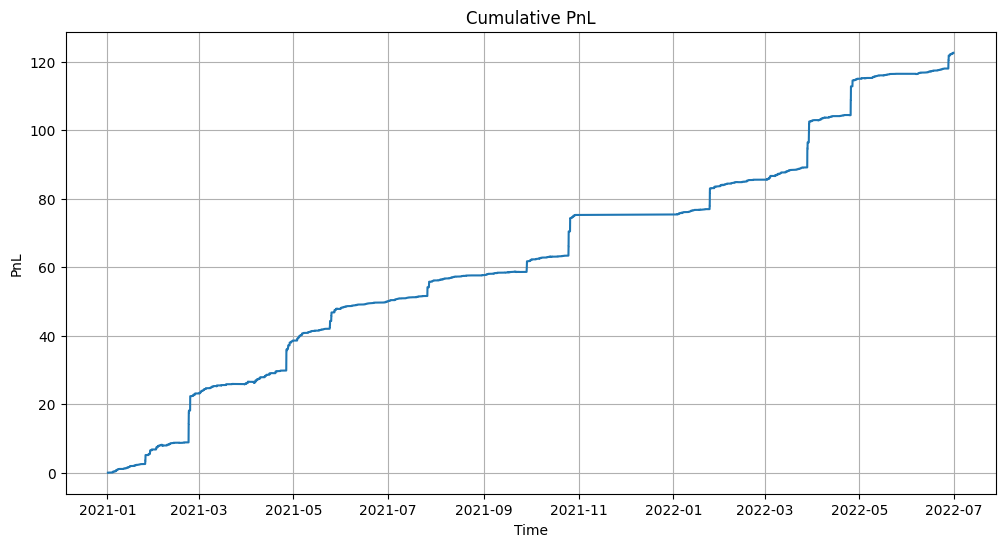

In [20]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#z-score strategy
def zscore_strategy(df, lookback=200, entry_threshold=2, exit_threshold=1):
    df['iv_spread'] = df['banknifty'] - df['nifty']

    # Rolling statistics
    df['spread_mean'] = df['iv_spread'].rolling(window=lookback).mean()
    df['spread_std'] = df['iv_spread'].rolling(window=lookback).std()
    df['z_score'] = (df['iv_spread'] - df['spread_mean']) / df['spread_std']

    # Signals
    df['position'] = 0
    df['trade_pnl'] = 0.0

    position = 0
    entry_z = 0
    entry_spread = 0
    entry_tte = 0

    for i in range(lookback, len(df)):
        current_z = df['z_score'].iloc[i]
        current_spread = df['iv_spread'].iloc[i]
        current_tte = df['tte'].iloc[i]

        # Exit conditions
        if position == 1 and (current_z >= -exit_threshold or i == len(df)-1):
            pnl = (current_spread - entry_spread) * (entry_tte ** 0.7)
            df.at[df.index[i], 'trade_pnl'] = pnl
            position = 0
        elif position == -1 and (current_z <= exit_threshold or i == len(df)-1):
            pnl = (entry_spread - current_spread) * (entry_tte ** 0.7)
            df.at[df.index[i], 'trade_pnl'] = pnl
            position = 0

        # Entry conditions
        if position == 0:
            if current_z <= -entry_threshold:
                position = 1
                entry_z = current_z
                entry_spread = current_spread
                entry_tte = current_tte
            elif current_z >= entry_threshold:
                position = -1
                entry_z = current_z
                entry_spread = current_spread
                entry_tte = current_tte

        df.at[df.index[i], 'position'] = position

    # Calculate cumulative PnL
    df['cumulative_pnl'] = df['trade_pnl'].cumsum()

    return df

# Performance metrics
def calculate_performance_metrics(df):
    trades = df[df['trade_pnl'] != 0]
    win_rate = len(trades[trades['trade_pnl'] > 0]) / len(trades) if len(trades) > 0 else 0
    avg_win = trades[trades['trade_pnl'] > 0]['trade_pnl'].mean() if len(trades[trades['trade_pnl'] > 0]) > 0 else 0
    avg_loss = trades[trades['trade_pnl'] < 0]['trade_pnl'].mean() if len(trades[trades['trade_pnl'] < 0]) > 0 else 0
    profit_factor = -avg_win / avg_loss if avg_loss != 0 else np.inf

    # Annualized Sharpe ratio (assuming minute data)
    returns = df['trade_pnl'] / 100000  # Assuming $100k capital
    sharpe = np.sqrt(252*6.25) * returns.mean() / returns.std() if returns.std() != 0 else 0

    # Max drawdown
    cumulative = df['cumulative_pnl']
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max)
    max_drawdown = drawdown.min()

    return {
        'num_trades': len(trades),
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'total_pnl': cumulative.iloc[-1]
    }

# Main execution
if __name__ == "__main__":
    #df = load_and_preprocess('data.parquet')
    result_df = zscore_strategy(df)
    metrics = calculate_performance_metrics(result_df)

    print("\nPerformance Metrics:")
    for k, v in metrics.items():
        print(f"{k:15}: {v:.2f}" if isinstance(v, float) else f"{k:15}: {v}")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(result_df['cumulative_pnl'])
    plt.title('Cumulative PnL')
    plt.xlabel('Time')
    plt.ylabel('PnL')
    plt.grid()
    plt.show()

In [73]:
df

,time,banknifty,nifty,tte,date,niftys,bankniftys,iv_spread,z_score,signal
0,2021-01-01 09:15:00,0.286058,0.199729,27,2021-01-01,0.425107,0.576386,0.086329,NaN,0
1,2021-01-01 09:16:00,0.285381,0.200433,27,2021-01-01,0.440769,0.564596,0.084948,NaN,0
2,2021-01-01 09:17:00,0.284233,0.200004,27,2021-01-01,0.431229,0.544603,0.084229,NaN,0
3,2021-01-01 09:18:00,0.286104,0.199860,27,2021-01-01,0.428023,0.577179,0.086244,NaN,0
4,2021-01-01 09:19:00,0.285539,0.198951,27,2021-01-01,0.407787,0.567348,0.086588,NaN,0
...,...,...,...,...,...,...,...,...,...,...
180851,2022-06-30 15:26:00,0.240701,0.214758,28,2022-06-30,0.759694,-0.213518,0.025943,0.741379,0
180852,2022-06-30 15:27:00,0.240875,0.216558,28,2022-06-30,0.799778,-0.210488,0.024317,-0.389375,0
180853,2022-06-30 15:28:00,0.242115,0.216794,28,2022-06-30,0.805010,-0.188901,0.025321,0.314918,0
180854,2022-06-30 15:29:00,0.243426,0.216455,28,2022-06-30,0.797485,-0.166053,0.026971,1.471200,0


In [11]:
pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 12.2 MB/s eta 0:00:00


In [12]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=585d835dd9e09898611b35dd33dba14ac46a0f94f019db5aa53900e6c278addb
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


Enhanced Strategy Metrics:
total_pnl      : 121.87
sharpe_ratio   : 15.18
win_rate       : 0.90
max_drawdown   : 0.28
num_trades     : 3691


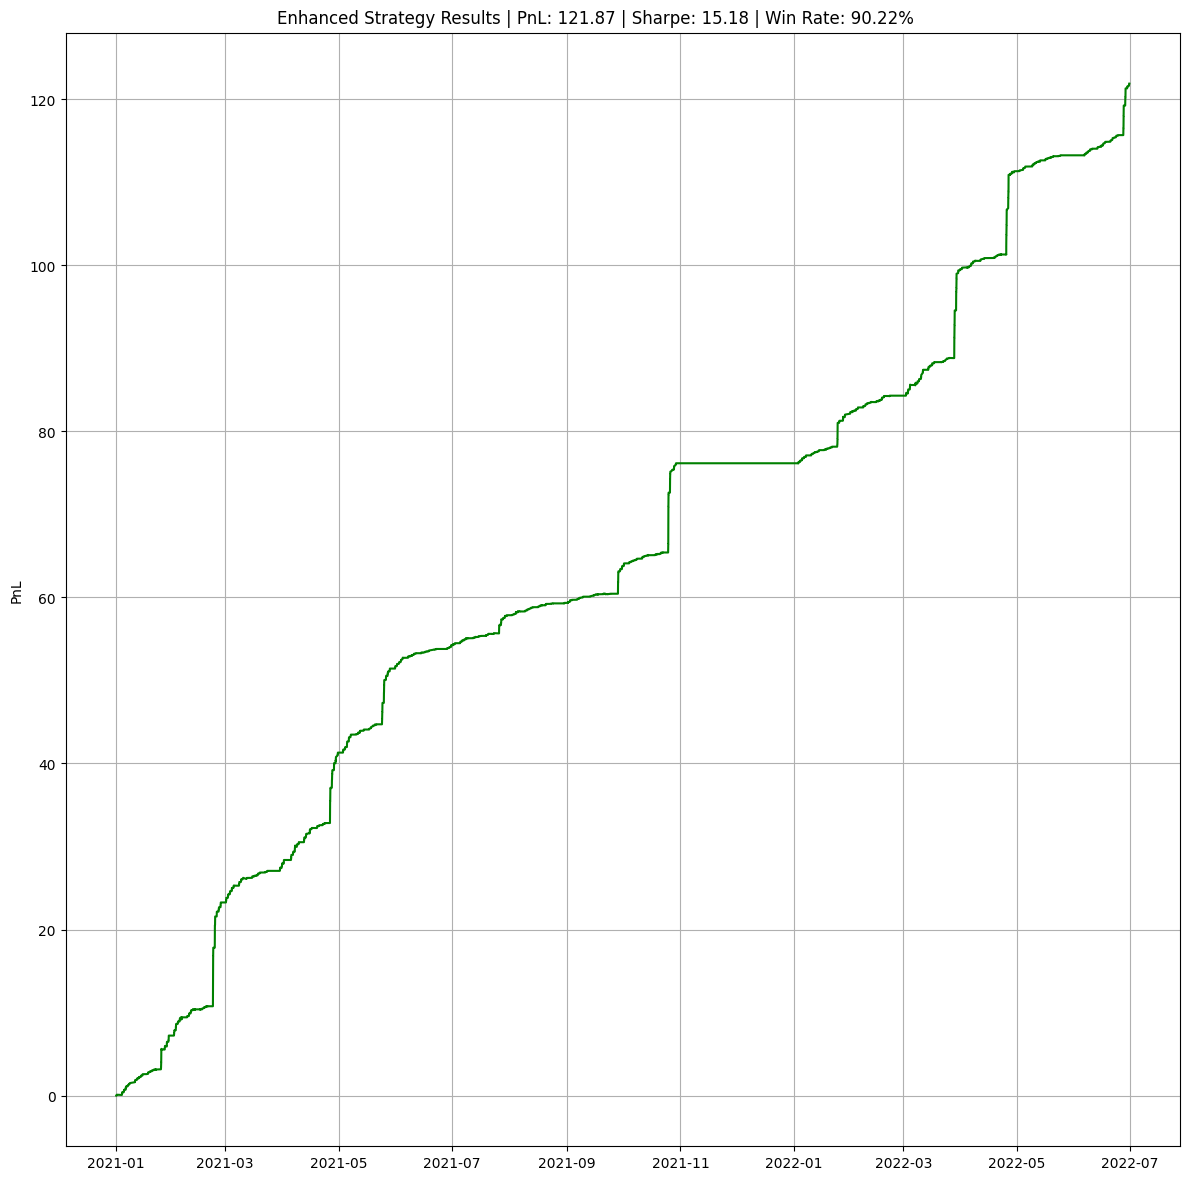

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from ta.momentum import RSIIndicator

def enhanced_strategy(df):
    # 1. Proper Spread Calculation (using raw IVs)
    df['iv_spread'] = df['banknifty'] - df['nifty']

    # 2. Kalman Filter for Dynamic Hedge Ratio
    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=df['iv_spread'].iloc[0],  # Use first spread value
        initial_state_covariance=1,
        observation_covariance=1,  # Reduced from 2
        transition_covariance=0.01  # Reduced from 0.05
    )
    state_means, _ = kf.filter(df['iv_spread'].values)
    df['kalman_spread'] = state_means

    # 3. Residual Calculation and Z-Score
    df['residual'] = df['iv_spread'] - df['kalman_spread']
    window = 60  # 1-hour lookback for minute data
    df['residual_mean'] = df['residual'].rolling(window).mean()
    df['residual_std'] = df['residual'].rolling(window).std()
    df['z_score'] = (df['residual'] - df['residual_mean']) / df['residual_std']

    # 4. RSI Filter
    rsi_window = 14  # Standard RSI period
    rsi_indicator = RSIIndicator(close=df['residual'], window=rsi_window)
    df['rsi'] = rsi_indicator.rsi()

    # 5. Trading Parameters
    entry_threshold = 2.0
    exit_threshold = 0.5
    rsi_overbought = 70
    rsi_oversold = 30
    max_holding_minutes=180  # 3hrs aligns with medium-frequency horizon

    # 6. Backtest Implementation
    df['position'] = 0
    df['trade_pnl'] = 0.0
    current_position = 0
    entry_price = 0
    entry_tte = 0
    entry_index = 0

    for i in range(window, len(df)):
        # Exit conditions
        if current_position != 0:
            time_in_trade = (df.index[i] - df.index[entry_index]).total_seconds() / 60
            should_exit = (
                (current_position == 1 and df['z_score'].iloc[i] >= -exit_threshold) or
                (current_position == -1 and df['z_score'].iloc[i] <= exit_threshold) or
                (time_in_trade >= max_holding_minutes)
            )

            if should_exit:
                pnl = current_position * (df['iv_spread'].iloc[i] - entry_price) * (entry_tte ** 0.7)
                df.at[df.index[i], 'trade_pnl'] = pnl
                current_position = 0

        # Entry conditions
        if current_position == 0:
            if (df['z_score'].iloc[i] <= -entry_threshold and
                df['rsi'].iloc[i] > rsi_oversold):
                current_position = 1
                entry_price = df['iv_spread'].iloc[i]
                entry_tte = df['tte'].iloc[i]
                entry_index = i
            elif (df['z_score'].iloc[i] >= entry_threshold and
                  df['rsi'].iloc[i] < rsi_overbought):
                current_position = -1
                entry_price = df['iv_spread'].iloc[i]
                entry_tte = df['tte'].iloc[i]
                entry_index = i

        df.at[df.index[i], 'position'] = current_position

    # 7. Performance Metrics
    df['cumulative_pnl'] = df['trade_pnl'].cumsum()
    trades = df[df['trade_pnl'] != 0]['trade_pnl']

    if len(trades) > 0:
        sharpe = np.sqrt(252*6.25) * trades.mean() / trades.std()
        win_rate = len(trades[trades > 0]) / len(trades)
        max_drawdown = (df['cumulative_pnl'].cummax() - df['cumulative_pnl']).max()
    else:
        sharpe, win_rate, max_drawdown = 0, 0, 0

    return df, {
        'total_pnl': df['cumulative_pnl'].iloc[-1],
        'sharpe_ratio': sharpe,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'num_trades': len(trades)
    }

# Visualization
def plot_results(df, metrics):
    fig, (ax3) = plt.subplots(1, 1, figsize=(12, 12), sharex=True)

    # PnL
    ax3.plot(df['cumulative_pnl'], label='Cumulative PnL', color='green')
    ax3.set_ylabel('PnL')
    ax3.grid()

    plt.suptitle(
        f"Enhanced Strategy Results | PnL: {metrics['total_pnl']:.2f} | "
        f"Sharpe: {metrics['sharpe_ratio']:.2f} | "
        f"Win Rate: {metrics['win_rate']:.2%}"
    )
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    result_df, metrics = enhanced_strategy(df)
    print("Enhanced Strategy Metrics:")
    for k, v in metrics.items():
        print(f"{k:15}: {v:.2f}" if isinstance(v, float) else f"{k:15}: {v}")
    plot_results(result_df, metrics)